In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using CSV, DataFrames
df = CSV.read(download("https://aprendeconalf.es/aprendizaje-automatico-practicas-julia/datos/tenis.csv"), DataFrame)

Row,Cielo,Temperatura,Humedad,Viento,Tenis
,String15,String15,String7,String7,String3
1,Soleado,Caluroso,Alta,Suave,No
2,Soleado,Caluroso,Alta,Fuerte,No
3,Nublado,Caluroso,Alta,Suave,Sí
4,Lluvioso,Moderado,Alta,Suave,Sí
5,Lluvioso,Frío,Normal,Suave,Sí
6,Lluvioso,Frío,Normal,Fuerte,No
7,Nublado,Frío,Normal,Fuerte,Sí
8,Soleado,Moderado,Alta,Suave,No
9,Soleado,Frío,Normal,Suave,Sí


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/ux0Te/src/scenes.jl:238


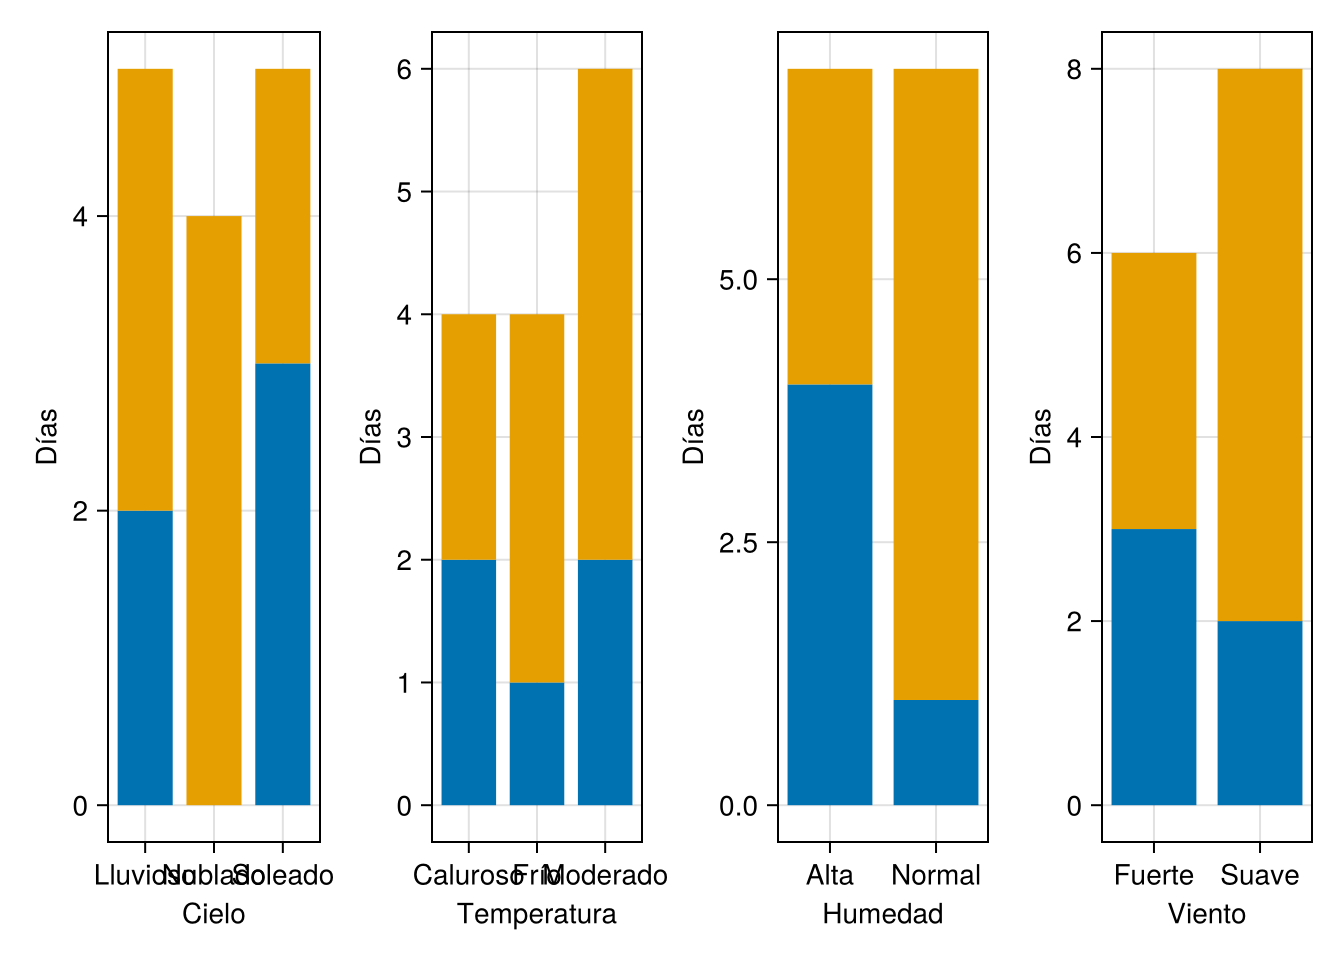

In [3]:
using GLMakie, AlgebraOfGraphics

function frecuencias(df::DataFrame, var::Symbol)
    # Calculamos el número de días de cada clase que se juega al tenis.
    frec = combine(groupby(df, [var, :Tenis]), nrow => :Días)
    # Dibujamos el diagrama de barras.
    plt = data(frec) * 
    mapping(var, :Días, stack = :Tenis, color = :Tenis, ) * 
    visual(BarPlot) 
    # Devolvemos el gráfico.
    return plt
end

fig = Figure()
draw!(fig[1, 1], frecuencias(df, :Cielo))
draw!(fig[1, 2], frecuencias(df, :Temperatura))
draw!(fig[1, 3], frecuencias(df, :Humedad))
draw!(fig[1, 4], frecuencias(df, :Viento))
fig

In [4]:
function gini(df::DataFrame, var::Symbol)
    # Calculamos el número de ejemplos.
    n = nrow(df)
    # Calculamos las frecuencias absolutas de cada clase.
    frec = combine(groupby(df, var), nrow => :ni)
    # Calculamos la proporción de cada clase.
    frec.p = frec.ni ./ n
    # Calculamos el índice de Gini.
    gini = 1 - sum(frec.p .^ 2)
    return gini
end

g0 = gini(df, :Tenis)

0.4591836734693877

In [5]:
using Tidier
# Dividimos el conjunto de ejemplos según la variable Humedad.
df_humedad_alta = @filter(df, Humedad == "Alta")
df_humedad_normal = @filter(df, Humedad == "Normal")
# Calculamos los tamaños de los subconjuntos de ejemplos.
n = nrow(df_humedad_alta), nrow(df_humedad_normal)
# Calculamos el índice de Gini de cada subconjunto.
gis = gini(df_humedad_alta, :Tenis), gini(df_humedad_normal, :Tenis)
# Calculamos media ponderada de los índices de Gini de los subconjuntos 
g_humedad = sum(gis .* n) / sum(n)
# Calculamos la reducción del índice de Gini.
g0 - g_humedad

0.09183673469387743

In [6]:
# Dividimos el conjunto de ejemplos según la variable `Viento`
df_viento_fuerte = @filter(df, Viento == "Fuerte")
df_viento_suave = @filter(df, Viento == "Suave")
# Calculamos los tamaños de los subconjuntos de ejemplos
n = nrow(df_viento_fuerte), nrow(df_viento_suave)
# Calculamos el índice de Gini de cada subconjunto
gis = gini(df_viento_fuerte, :Tenis), gini(df_viento_suave, :Tenis)
# Calculamos media ponderada de los índices de Gini de los subconjuntos
g_viento = sum(gis .* n) / sum(n)
# Calculamos la reducción del índice de Gini
g0 - g_viento

0.030612244897959162

In [7]:
using DecisionTree, CategoricalArrays
# Variables predictoras.
X = Matrix(select(df, Not(:Tenis)))
# Variable objetivo.
y = df.Tenis
# Convertir las variables categóricas a enteros.
X = hcat([levelcode.(categorical(X[:, j])) for j in 1:size(X, 2)]...)
# Convertir la variable objetivo a enteros.
y = levelcode.(categorical(y))
tree = DecisionTreeClassifier(max_depth=3)
fit!(tree, X, y)

DecisionTreeClassifier
max_depth:                3
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  [1, 2]
root:                     Decision Tree
Leaves: 6
Depth:  3

In [8]:
print_tree(tree, feature_names=names(df)[1:end-1])

Feature 3: "Humedad" < 2.0 ?


├─ Feature 1: "Cielo" < 3.0 ?
    ├─ Feature 4: "Viento" < 2.0 ?
        ├─ 2 : 1/2
        └─ 2 : 2/2
    └─ 1 : 3/3
└─ Feature 4: "Viento" < 2.0 ?
    ├─ Feature 1: "Cielo" < 2.0 ?
        ├─ 1 : 1/1
        └─ 2 : 2/2
    └─ 2 : 4/4
